In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Inputs

In [2]:
# параметры распределений
# двумерное нормальное распределение задается вектором матожиданий mu размерности 2 и матрицей ковариации размерности 2x2

mu0  = [-2., 2.]                 
cov0 = make_spd_matrix(n_dim=2, random_state=223)  # сделаем дисперсию случайной

mu1  = [3., 1.]
cov1 = make_spd_matrix(n_dim=2, random_state=2556)

In [3]:
print("1. mu: {}\ncov:\n{}\n-------\n2. mu: {}\ncov:\n{}".format(mu0, cov0, mu1, cov1))

1. mu: [-2.0, 2.0]
cov:
[[ 2.39372096 -0.53673463]
 [-0.53673463  0.51274882]]
-------
2. mu: [3.0, 1.0]
cov:
[[1.92219028 1.00518736]
 [1.00518736 1.75169592]]


In [4]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [5]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu0), covariance_matrix=torch.tensor(cov0, dtype=torch.float32))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu1), covariance_matrix=torch.tensor(cov1, dtype=torch.float32))

In [6]:
d0.sample()

tensor([-2.7685,  1.7074])

### Train

In [7]:
layer = nn.Linear(in_features=2, out_features=1)  # x0, x1: 2 признака на входе модели; y: выход полносвязного слоя
print([p.data[0] for p in layer.parameters()])
opt = optim.SGD(lr=1e-2, params=list(layer.parameters()))

[tensor([-0.0157, -0.5430]), tensor(0.5529)]


In [8]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    x, y = sample(d0, d1, 1024)
    out = F.sigmoid(layer(x))
    opt.zero_grad()
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    opt.step()

Ошибка после 0 итераций: 0.631999
Ошибка после 1 итераций: 0.122548
Ошибка после 2 итераций: 0.101670
Ошибка после 3 итераций: 0.094428
Ошибка после 4 итераций: 0.089391
Ошибка после 5 итераций: 0.086452
Ошибка после 6 итераций: 0.084385
Ошибка после 7 итераций: 0.083467
Ошибка после 8 итераций: 0.081565
Ошибка после 9 итераций: 0.082093
Ошибка после 10 итераций: 0.081031
Ошибка после 11 итераций: 0.079551
Ошибка после 12 итераций: 0.079643
Ошибка после 13 итераций: 0.081525
Ошибка после 14 итераций: 0.078570
Ошибка после 15 итераций: 0.079773
Ошибка после 16 итераций: 0.079417
Ошибка после 17 итераций: 0.078598
Ошибка после 18 итераций: 0.078423
Ошибка после 19 итераций: 0.078717


In [9]:
print([p.data[0] for p in layer.parameters()]) # параметры модели после оптимизации

[tensor([ 2.3343, -1.4537]), tensor(1.00000e-02 *
       -2.2044)]


### Inference

<Figure size 504x360 with 0 Axes>

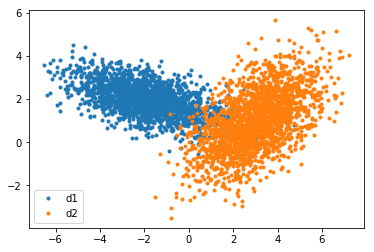

In [10]:
zx0, zy0 = np.random.multivariate_normal(np.array(mu0), cov0, 2000).T
zx1, zy1 = np.random.multivariate_normal(np.array(mu1), cov1, 2000).T

plt.figure(figsize=(7, 5))

fig = plt.figure()
plt.plot(zx0, zy0, '.', label='d1')
plt.plot(zx1, zy1, '.', label='d2')
plt.legend()

In [11]:
# Our 2-dimensional distribution will be over variables X and Y
N = 50
X = np.linspace(-6, 6, N)
Y = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z0 = multivariate_normal(mu0, cov0).pdf(pos)*10
Z1 = multivariate_normal(mu1, cov1).pdf(pos)*10

# Create a surface plot and projected filled contour plot under it.
fig = pylab.figure(figsize=(7, 5))
axes = Axes3D(fig)

# sigmoid
xy = np.column_stack([X.flat, X.flat])
xy_tensor = torch.tensor(xy, dtype=torch.float)

with torch.no_grad():
    z = F.sigmoid(layer(xy_tensor)).numpy()

z = z.reshape(X.shape)

axes.plot_surface(X, Y, Z0, linewidth=1, antialiased=True, cmap=cm.Oranges)
axes.plot_surface(X, Y, Z1, linewidth=1, antialiased=True, cmap=cm.Oranges)


axes.plot_surface(X, Y, z, linewidth=1, antialiased=True, alpha=0.4, color='blue')

# rotate if it's needed
# axes.view_init(elev=25, azim=80)

AttributeError: 'numpy.ndarray' object has no attribute 'pdf'